# Inferensi

Install requirement

In [ ]:
%pip install -r "../requirements.txt"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 50.8 MB/s eta 0:00:00


Import library

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.models as models
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from model_architecture import UNet_SKResNeXt50, UNet_SKResNeXt50_Modifikasi_A, UNet_SKResNeXt50_Modifikasi_B
import seaborn as sns
import rasterio
import datetime
from tqdm import tqdm
import time
from PIL import Image
import csv

Inisialisasi Class Dataset

In [2]:
class SatelliteDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = sorted(os.listdir(image_dir))
        self.masks = sorted(os.listdir(mask_dir))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.masks[idx])

        # Read 16-bit image with rasterio (shape: C, H, W)
        with rasterio.open(img_path) as src:
            image = src.read().astype(np.float32) / 65535.0  # normalize to [0,1]

        # Convert image to tensor (float32)
        image = torch.from_numpy(image).float()  # shape: (C, H, W)

        # Load mask (assume 16-bit single channel segmentation mask)
        mask = np.array(Image.open(mask_path))
        mask = torch.tensor(mask, dtype=torch.long)  # shape: (H, W)

        # Optional transform (e.g., resizing) — apply to image & mask if needed
        if self.transform:
            # You need to implement custom transform for 4-channel tensors
            image, mask = self.transform(image, mask)

        return image, mask

Inisialisasi Device (GPU/CPU)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


Inisialisasi Model

In [4]:
model_baseline_32x4d_8020 = UNet_SKResNeXt50(in_channels=4, out_channels=6, cardinality=32, bwidth=4).to(device)
model_modifikasi_32x4d_8020 = UNet_SKResNeXt50_Modifikasi_A(in_channels=4, out_channels=6, cardinality=32, bwidth=4).to(device)

model_baseline_8x14d_8020 = UNet_SKResNeXt50(in_channels=4, out_channels=6, cardinality=8, bwidth=14).to(device)
model_modifikasi_8x14d_8020 = UNet_SKResNeXt50_Modifikasi_A(in_channels=4, out_channels=6, cardinality=8, bwidth=14).to(device)

model_baseline_4x24d_8020 = UNet_SKResNeXt50(in_channels=4, out_channels=6, cardinality=4, bwidth=24).to(device)
model_modifikasi_4x24d_8020 = UNet_SKResNeXt50_Modifikasi_A(in_channels=4, out_channels=6, cardinality=4, bwidth=24).to(device)

In [14]:
baseline_32x4d_path_8020 = "../ape_train/output/baseline_32x4d/best_model/unet_skresnext50_baseline_best.pt"
modifikasi_32x4d_path_8020 = "../ape_train/output/modifikasi_32x4d/best_model/unet_skresnext50_modifikasiA_best.pt"

baseline_8x14d_path_8020 = "../ape_train/output/baseline_8x14d/best_model/unet_skresnext50_baseline_best.pt"
modifikasi_8x14d_path_8020 = "../ape_train/output/modifikasi_8x14d/best_model/unet_skresnext50_modifikasiA_best.pt"

baseline_4x24d_path_8020 = "../ape_train/output/baseline_4x24d/best_model/unet_skresnext50_baseline_best.pt"
modifikasi_4x24d_path_8020 = "../ape_train/output/modifikasi_4x24d/best_model/unet_skresnext50_modifikasiA_best.pt"


Load Model

#### Load satu model

In [ ]:
model_baseline_32x4d_8020.load_state_dict(torch.load(baseline_32x4d_path_8020))
model_baseline_32x4d_8020.eval()

UNet_SKResNeXt50(
  (encoder): SKResNeXt(
    (stem): Sequential(
      (0): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): resnext_block(
        (conv1): Conv2d(64, 112, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(112, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (skconv): SKConv(
          (conv3): Conv2d(112, 112, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=8, bias=False)
          (bn3): BatchNorm2d(112, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv5): Conv2d(112, 112, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2), groups=8, bias=False)
          (bn5): BatchNorm2d(112, eps=1e-0

#### Load All Model

In [15]:
model_baseline_32x4d_8020.load_state_dict(torch.load(baseline_32x4d_path_8020))
model_baseline_32x4d_8020.eval()

model_modifikasi_32x4d_8020.load_state_dict(torch.load(modifikasi_32x4d_path_8020))
model_modifikasi_32x4d_8020.eval()

model_baseline_8x14d_8020.load_state_dict(torch.load(baseline_8x14d_path_8020))
model_baseline_8x14d_8020.eval()

model_modifikasi_8x14d_8020.load_state_dict(torch.load(modifikasi_8x14d_path_8020))
model_modifikasi_8x14d_8020.eval()

model_baseline_4x24d_8020.load_state_dict(torch.load(baseline_4x24d_path_8020))
model_baseline_4x24d_8020.eval()

model_modifikasi_4x24d_8020.load_state_dict(torch.load(modifikasi_4x24d_path_8020))
model_modifikasi_4x24d_8020.eval()

C:\Users\algha\AppData\Local\Temp\ipykernel_36972\37224765.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_baseline_32x4d_8020.load_state_dict(torch.load(baseline_

UNet_SKResNeXt50_Modifikasi_A(
  (encoder): SKResNeXt(
    (stem): Sequential(
      (0): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): resnext_block(
        (conv1): Conv2d(64, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (skconv): SKConv(
          (conv3): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=4, bias=False)
          (bn3): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv5): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2), groups=4, bias=False)
          (bn5): BatchNorm2d(96, eps

#### Load Data Test

In [16]:
# Load dataset dari localstorage collab
image_dir = "data_test\data_inferensi"
mask_dir = "data_test\label_inferensi"

In [17]:
datatest_20 = SatelliteDataset(image_dir, mask_dir, transform=None)

# Set seed
generator = torch.Generator().manual_seed(42)

# Inisialisasi Batch Size
batch_size = 16

test_loader_20 = DataLoader(datatest_20, batch_size=batch_size, shuffle=False)

In [18]:
print("Jumlah data pada set test:", len(datatest_20))

Jumlah data pada set test: 2025


## Hitung Jumlah Parameter

In [19]:
# Fungsi untuk menghitung total parameter yang dapat dilatih
def count_trainable_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [20]:
# Daftar model dan labelnya (tanpa (80:20))
models = {
    "Baseline 32x4d": model_baseline_32x4d_8020,
    "Modifikasi 32x4d": model_modifikasi_32x4d_8020,
    "Baseline 8x14d": model_baseline_8x14d_8020,
    "Modifikasi 8x14d": model_modifikasi_8x14d_8020,
    "Baseline 4x24d": model_baseline_4x24d_8020,
    "Modifikasi 4x24d": model_modifikasi_4x24d_8020,
}

# Hitung dan cetak jumlah parameter untuk setiap model
print(f"{'Model':<25} | {'Jumlah Parameter':>20}")
print("-" * 50)
for name, model in models.items():
    params = count_trainable_params(model)
    print(f"{name:<25} | {params:>20,}")

Model                     |     Jumlah Parameter
--------------------------------------------------
Baseline 32x4d            |           73,809,414
Modifikasi 32x4d          |           84,824,990
Baseline 8x14d            |           63,073,302
Modifikasi 8x14d          |           71,621,238
Baseline 4x24d            |           52,774,342
Modifikasi 4x24d          |           59,166,446


## Hitung Akurasi

Hitung nilai akurasi pada set test

In [21]:
# Pastikan label kelas sesuai urutan
class_labels = ["Background", "Built-up", "Farmland", "Forest", "Meadow", "Water"]
num_classes = len(class_labels)

# Inisialisasi confusion matrix
conf_matrix = np.zeros((num_classes, num_classes), dtype=int)

model_baseline_32x4d_8020.eval() # Sesuaikan model yang mau di test
with torch.no_grad():
    for images, masks in test_loader_20:
        images, masks = images.to(device), masks.to(device)

        outputs = model_baseline_32x4d_8020(images)
        preds = torch.argmax(outputs, dim=1)

        # Konversi ke NumPy dan flatten
        y_true_batch = masks.view(-1).cpu().numpy()
        y_pred_batch = preds.view(-1).cpu().numpy()

        # Update confusion matrix
        conf_matrix += confusion_matrix(y_true_batch, y_pred_batch, labels=list(range(num_classes)))

# ✅ Hitung dan print mIoU
intersection = np.diag(conf_matrix)
union = np.sum(conf_matrix, axis=1) + np.sum(conf_matrix, axis=0) - intersection
iou_per_class = intersection / (union + 1e-10)
mean_iou = np.mean(iou_per_class)

# Overall Accuracy
total_correct = np.trace(conf_matrix)
total_pixels = np.sum(conf_matrix)
accuracy = total_correct / total_pixels

# Precision, Recall, F1 per class
precision = np.zeros(num_classes)
recall = np.zeros(num_classes)
f1 = np.zeros(num_classes)

for i in range(num_classes):
    tp = conf_matrix[i, i]
    fp = np.sum(conf_matrix[:, i]) - tp
    fn = np.sum(conf_matrix[i, :]) - tp

    precision[i] = tp / (tp + fp + 1e-10)
    recall[i] = tp / (tp + fn + 1e-10)
    f1[i] = 2 * precision[i] * recall[i] / (precision[i] + recall[i] + 1e-10)

# Macro average (rata-rata antar kelas)
precision_macro = np.mean(precision)
recall_macro = np.mean(recall)
f1_macro = np.mean(f1)

# -------------------------------
# ✅ CETAK HASIL
# -------------------------------
print(f"\nOverall Accuracy: {accuracy:.4f}")
print(f"Precision : {precision_macro:.4f}")
print(f"Recall :    {recall_macro:.4f}")
print(f"F1 Score :  {f1_macro:.4f}")
print(f"Mean IoU (mIoU):   {mean_iou:.4f}")

print("\nPer-Class Metrics:")
for i, label in enumerate(class_labels):
    print(f"{label:<10} - Precision: {precision[i]:.4f}, Recall: {recall[i]:.4f}, F1: {f1[i]:.4f}, IoU: {iou_per_class[i]:.4f}")


Overall Accuracy: 0.7031
Precision : 0.7250
Recall :    0.7060
F1 Score :  0.7058
Mean IoU (mIoU):   0.5578

Per-Class Metrics:
Background - Precision: 0.4951, Recall: 0.6803, F1: 0.5731, IoU: 0.4017
Built-up   - Precision: 0.8378, Recall: 0.7596, F1: 0.7967, IoU: 0.6622
Farmland   - Precision: 0.7633, Recall: 0.5387, F1: 0.6316, IoU: 0.4616
Forest     - Precision: 0.8271, Recall: 0.9070, F1: 0.8652, IoU: 0.7624
Meadow     - Precision: 0.5208, Recall: 0.6514, F1: 0.5789, IoU: 0.4073
Water      - Precision: 0.9058, Recall: 0.6989, F1: 0.7890, IoU: 0.6515


## Visualisasi Hasil Prediksi

Visualisasi satu gambar

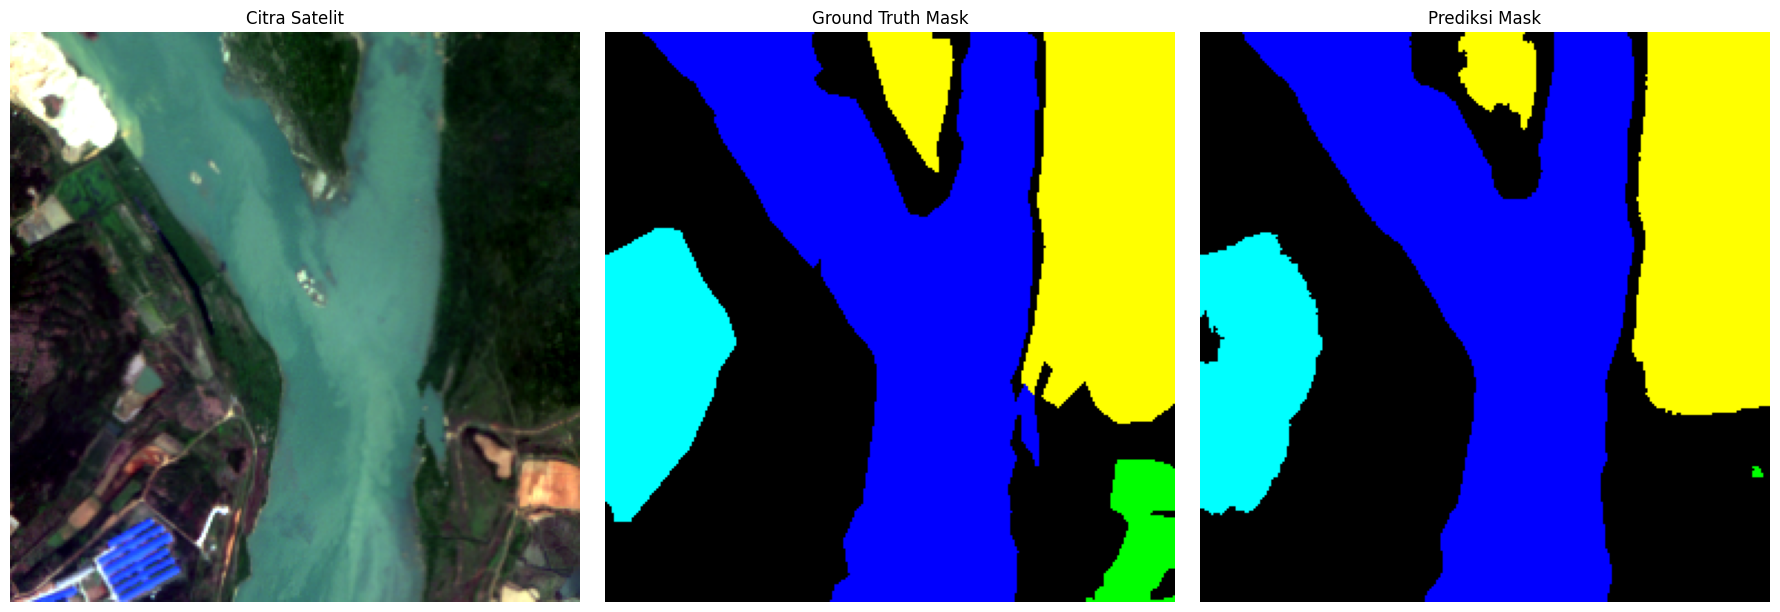

In [22]:
# Custom resize transform untuk tensor (4-channel)
def resize_tensor(image, size=(256, 256)):
    return F.interpolate(image.unsqueeze(0), size=size, mode='bilinear', align_corners=False).squeeze(0)

def decode_segmap(mask):
    """
    Converts mask index to RGB colors.
    """
    label_colors = np.array([
        [0, 0, 0],       # 0 Background -> Hitam
        [255, 0, 0],     # 1 Built-up   -> Merah
        [0, 255, 0],     # 2 Farmland   -> Hijau
        [0, 255, 255],   # 3 Forest     -> Cyan
        [255, 255, 0],   # 4 Meadow     -> Kuning
        [0, 0, 255],     # 5 Water      -> Biru
    ])

    r = np.zeros_like(mask).astype(np.uint8)
    g = np.zeros_like(mask).astype(np.uint8)
    b = np.zeros_like(mask).astype(np.uint8)

    for label in range(0, len(label_colors)):
        idx = mask == label
        r[idx] = label_colors[label, 0]
        g[idx] = label_colors[label, 1]
        b[idx] = label_colors[label, 2]

    rgb = np.stack([r, g, b], axis=2)
    return rgb

def inference_single_image(image_path, mask_path=None):
    # Load image (BGR-NIR, 16-bit)
    with rasterio.open(image_path) as src:
        image = src.read()  # (C, H, W), C=4 (e.g. B, G, R, NIR)
        image = image.astype(np.float32) / 65535.0  # Normalize 16-bit

    # Save original image for visualization
    image_vis = image.copy()

    # Convert to tensor
    image = torch.tensor(image, dtype=torch.float32)

    # Resize
    image = resize_tensor(image, size=(256, 256))

    # Add batch dimension
    image = image.unsqueeze(0).to(device)  # (1, C, H, W)

    # Predict
    with torch.no_grad():
        output = model_baseline_32x4d_8020(image)  # (B, num_classes, H, W) # GANTI INI JANGAN LUPA
        pred = torch.argmax(output, dim=1)

    pred = pred.squeeze(0).cpu().numpy()

    # Load ground truth mask
    if mask_path is not None:
        gt_mask = np.array(Image.open(mask_path))
    else:
        gt_mask = None

    return image_vis, pred, gt_mask

def normalize_band(band, low=2, high=98):
    p_low, p_high = np.percentile(band, (low, high))
    band = np.clip((band - p_low) / (p_high - p_low + 1e-8), 0, 1)
    return band

def visualize(image_vis, prediction, ground_truth=None):
    # Ambil band RGB dari image_vis (diasumsikan urutan: B, G, R, NIR)
    red_band   = image_vis[2]
    green_band = image_vis[1]
    blue_band  = image_vis[0]

    # Normalisasi kontras tiap band
    red_band   = normalize_band(red_band)
    green_band = normalize_band(green_band)
    blue_band  = normalize_band(blue_band)

    # Gabungkan jadi RGB image
    rgb_image = np.stack([red_band, green_band, blue_band], axis=-1)

    # Decode mask
    pred_color = decode_segmap(prediction)
    gt_color = decode_segmap(ground_truth) if ground_truth is not None else np.zeros_like(pred_color)

    # Plot hasil
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    axs[0].imshow(rgb_image)
    axs[0].set_title('Citra Satelit')
    axs[0].axis('off')

    axs[1].imshow(gt_color)
    axs[1].set_title('Ground Truth Mask')
    axs[1].axis('off')

    axs[2].imshow(pred_color)
    axs[2].set_title('Prediksi Mask')
    axs[2].axis('off')

    plt.tight_layout()
    plt.show()


# 6. Inference example
image_path = "../ape_train/dataset/dataset_16bit/GF2_PMS1__L1A0001491484-MSS1_patch_5_20.tif"
mask_path = "../ape_train/dataset/label_index/GF2_PMS1__L1A0001491484-MSS1_5label_patch_5_20.png"

image_vis, prediction, ground_truth = inference_single_image(image_path, mask_path)
visualize(image_vis, prediction, ground_truth)


#### Visualisasi Hasil Prediksi 3 Model

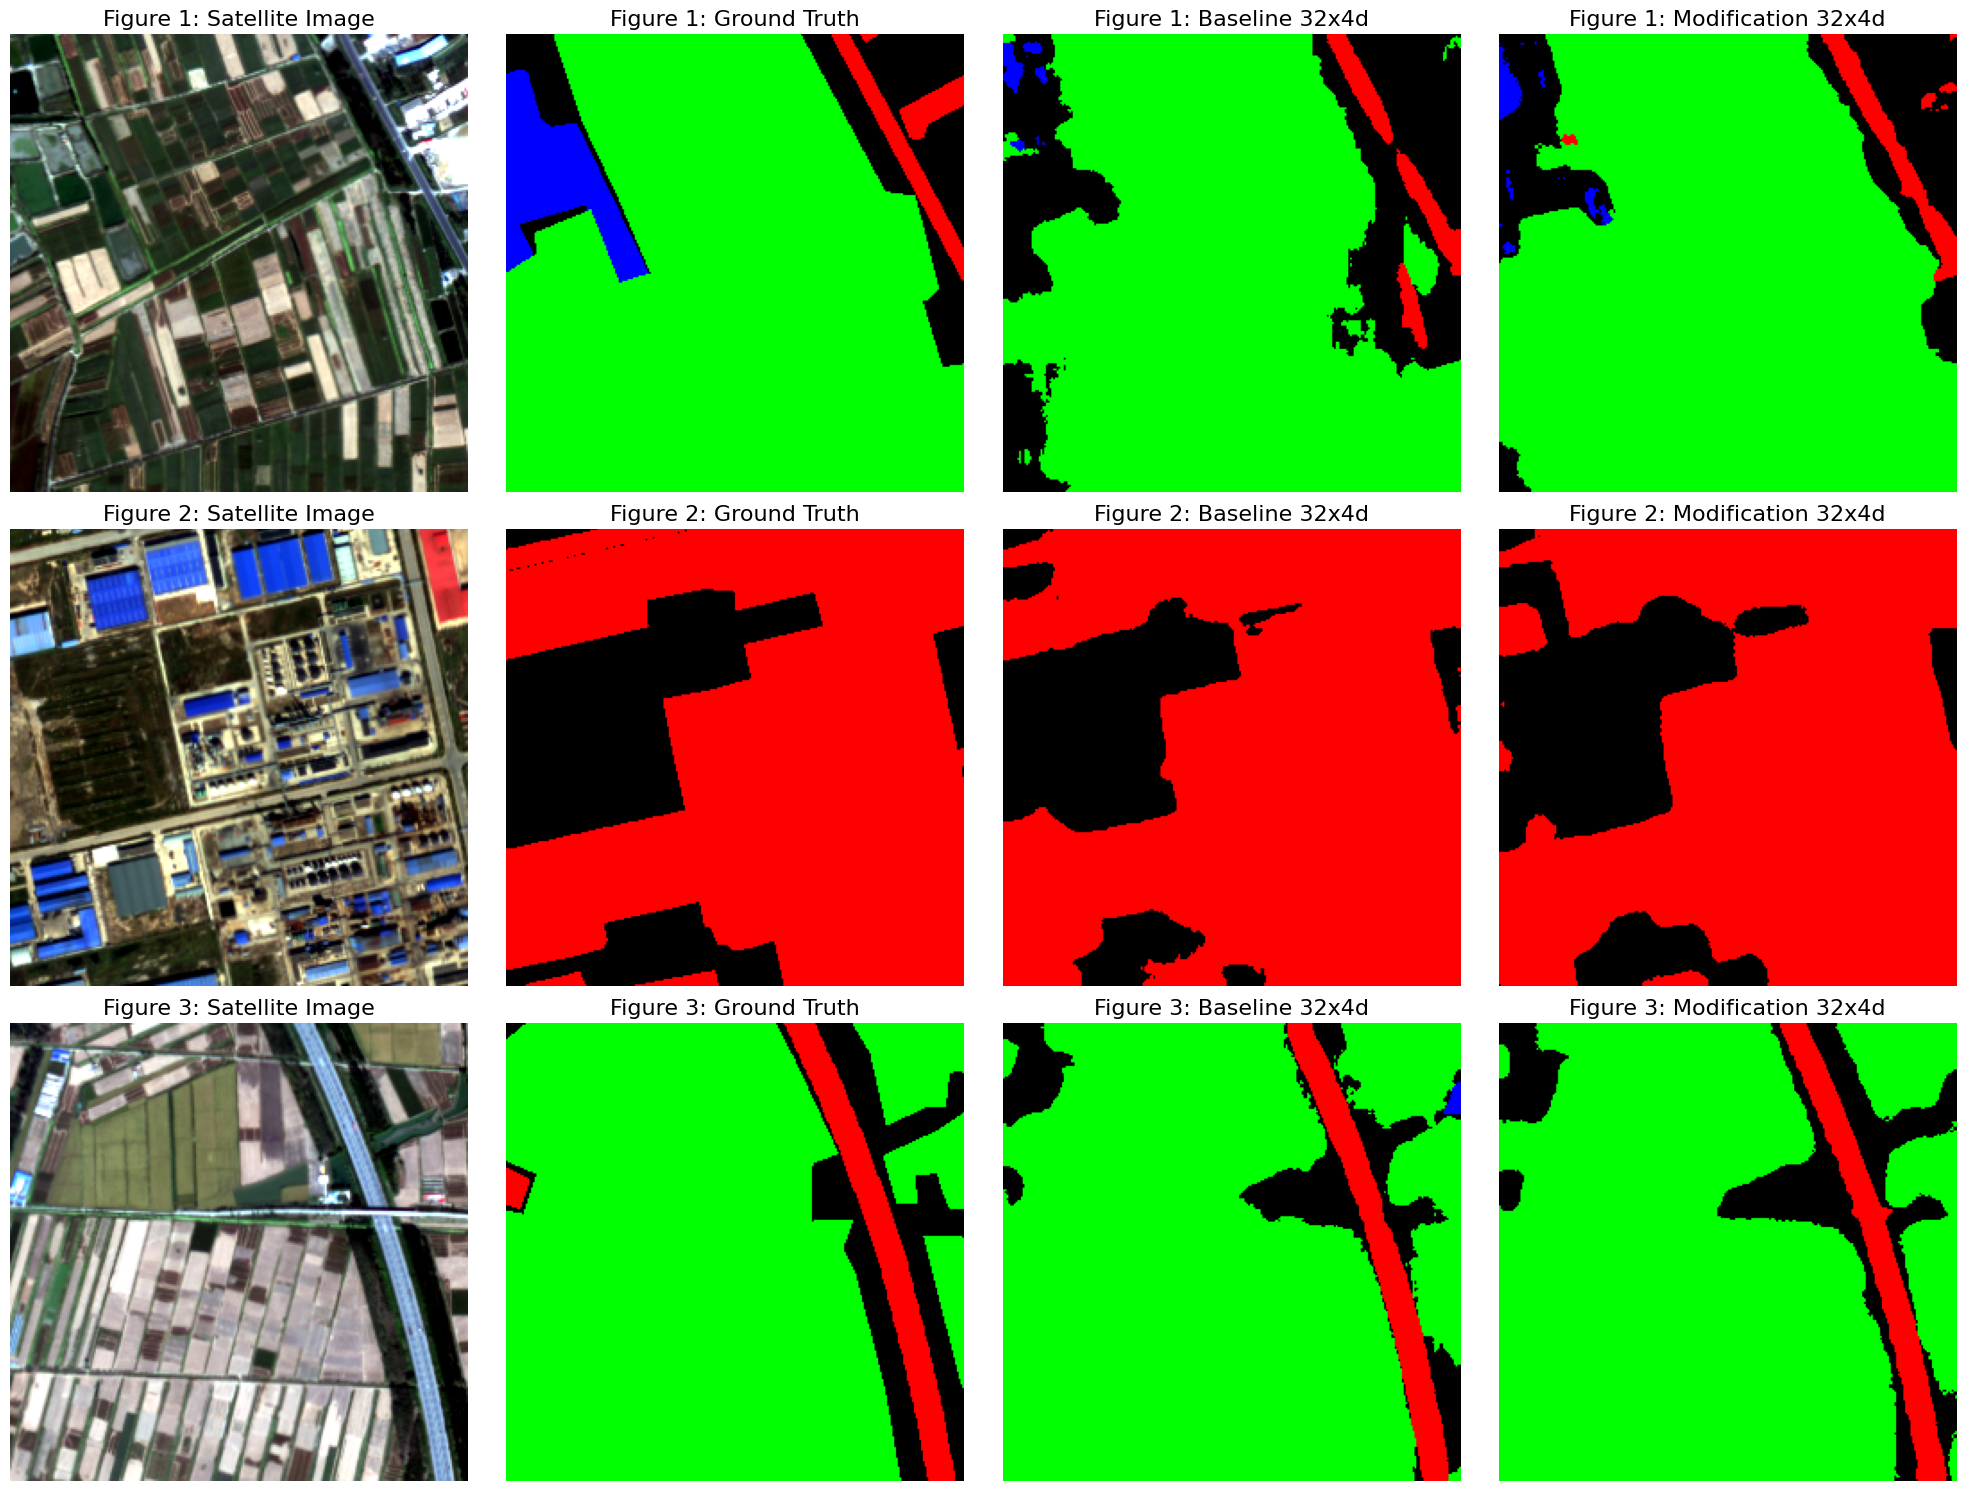

In [23]:
def resize_tensor(image, size=(256, 256)):
    return F.interpolate(image.unsqueeze(0), size=size, mode='bilinear', align_corners=False).squeeze(0)

def decode_segmap(mask):
    label_colors = np.array([
        [0, 0, 0],       # 0 Background
        [255, 0, 0],     # 1 Built-up
        [0, 255, 0],     # 2 Farmland
        [0, 255, 255],   # 3 Forest
        [255, 255, 0],   # 4 Meadow
        [0, 0, 255],     # 5 Water
    ])

    r = np.zeros_like(mask).astype(np.uint8)
    g = np.zeros_like(mask).astype(np.uint8)
    b = np.zeros_like(mask).astype(np.uint8)

    for label in range(len(label_colors)):
        idx = mask == label
        r[idx] = label_colors[label, 0]
        g[idx] = label_colors[label, 1]
        b[idx] = label_colors[label, 2]

    return np.stack([r, g, b], axis=2)

def normalize_band(band, low=2, high=98):
    p_low, p_high = np.percentile(band, (low, high))
    return np.clip((band - p_low) / (p_high - p_low + 1e-8), 0, 1)

# --- INFERENCE SETUP ---

# Load model yang dibutuhkan
model_baseline = model_baseline_32x4d_8020
model_modifikasi = model_modifikasi_32x4d_8020

# Pastikan semuanya ke device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_baseline.to(device).eval()
model_modifikasi.to(device).eval()

# Hanya dua model: Baseline dan Modifikasi
models = {
    "Baseline 32x4d": model_baseline,
    "Modification 32x4d": model_modifikasi,
}

# Daftar image dan mask
image_mask_pairs = [
    (
        ## Data Image yang bukan di set test
        "data_visualisasi/GF2_PMS1__L1A0001064454-MSS1_patch_13_7.tif",
        "data_visualisasi/GF2_PMS1__L1A0001064454-MSS1_5label_patch_13_7.png"
    ),
    (
        ## Data Image yang memiliki 4 kelas dan beradapa pada set test (1)
        "data_visualisasi/GF2_PMS1__L1A0001064454-MSS1_patch_25_9.tif",
        "data_visualisasi/GF2_PMS1__L1A0001064454-MSS1_5label_patch_25_9.png"
    ),
    (
        ## Data Image yang memiliki 4 kelas dan berada pada set test (2)
        "data_visualisasi/GF2_PMS1__L1A0001064454-MSS1_patch_10_10.tif",
        "data_visualisasi/GF2_PMS1__L1A0001064454-MSS1_5label_patch_10_10.png"
    ),
]

def inference_with_model(image_tensor, model):
    image = resize_tensor(image_tensor, size=(256, 256)).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(image)
        pred = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()
    return pred

def visualize_multiple(images_and_preds):
    num_images = len(images_and_preds)
    num_models = len(models)

    fig, axs = plt.subplots(num_images, 2 + num_models, figsize=(5 * (2 + num_models), 5 * num_images))

    for i, (image_vis, gt_mask, preds_dict) in enumerate(images_and_preds):
        # RGB image
        red   = normalize_band(image_vis[2])
        green = normalize_band(image_vis[1])
        blue  = normalize_band(image_vis[0])
        rgb_image = np.stack([red, green, blue], axis=-1)

        # Ground truth
        gt_color = decode_segmap(gt_mask)

        if num_images == 1:
            row = axs
        else:
            row = axs[i]

        row[0].imshow(rgb_image)
        row[0].set_title(f"Figure {i+1}: Satellite Image", fontsize=16)
        row[0].axis('off')

        row[1].imshow(gt_color)
        row[1].set_title(f"Figure {i+1}: Ground Truth", fontsize=16)
        row[1].axis('off')

        for j, (model_name, pred_mask) in enumerate(preds_dict.items()):
            pred_color = decode_segmap(pred_mask)
            row[j + 2].imshow(pred_color)
            row[j + 2].set_title(f"Figure {i+1}: {model_name}", fontsize=16)
            row[j + 2].axis('off')

    plt.tight_layout()
    plt.show()

# Jalankan inference dan kumpulkan hasilnya
results = []

for image_path, mask_path in image_mask_pairs:
    with rasterio.open(image_path) as src:
        image = src.read().astype(np.float32) / 65535.0
    image_tensor = torch.tensor(image, dtype=torch.float32)
    image_vis = image.copy()
    gt_mask = np.array(Image.open(mask_path))

    preds_dict = {}
    for model_name, model in models.items():
        preds_dict[model_name] = inference_with_model(image_tensor, model)

    results.append((image_vis, gt_mask, preds_dict))

# Tampilkan semua hasil
visualize_multiple(results)

## Cek Waktu Inferensi

Hitung Waktu Inferensi 5 kali Lalu rata ratakan

In [ ]:
# Direktori untuk menyimpan log inferensi waktu
inference_time_dir = "Inference-Time"
os.makedirs(inference_time_dir, exist_ok=True)

# Konfigurasi model dan nama file
model_configs = [
    ("model_baseline_32x4d_8020", "baseline_32x4d"),
    ("model_modifikasi_32x4d_8020", "modifikasi_32x4d"),
    ("model_baseline_8x14d_8020", "baseline_8x14d"),
    ("model_modifikasi_8x14d_8020", "modifikasi_8x14d"),
    ("model_baseline_4x24d_8020", "baseline_4x24d"),
    ("model_modifikasi_4x24d_8020", "modifikasi_4x24d"),
]

repeat = 5

# Loop semua model
for model_var_name, model_name in model_configs:
    print(f"\n🚀 Evaluasi waktu inferensi: {model_name}")

    # Ambil model dari variabel global
    model = globals()[model_var_name]
    model.eval()
    model.to(device)

    # Untuk menyimpan waktu setiap perulangan
    all_total_times = []
    all_avg_time_per_batch = []
    all_avg_time_per_image = []

    for i in range(repeat):
        print(f"\n⏱️ Iterasi inferensi ke-{i+1}/{repeat}")
        total_images = 0
        total_batches = 0
        start_time = time.time()

        with torch.no_grad():
            for images, masks in tqdm(test_loader_20, desc=f"Inferensi ke-{i+1}", unit="batch"):
                images = images.to(device)
                outputs = model(images)
                total_images += images.size(0)
                total_batches += 1

        end_time = time.time()
        total_time = end_time - start_time
        avg_time_batch = total_time / total_batches
        avg_time_image = total_time / total_images

        all_total_times.append(total_time)
        all_avg_time_per_batch.append(avg_time_batch)
        all_avg_time_per_image.append(avg_time_image)

        print(f"🟢 Iterasi {i+1} selesai: {total_time:.2f} detik")
        print(f"  ⏱️ Per batch : {avg_time_batch:.4f} detik")
        print(f"  🖼️ Per gambar: {avg_time_image:.4f} detik")

    # Hitung rata-rata dari semua iterasi
    mean_total_time = sum(all_total_times) / repeat
    mean_avg_time_batch = sum(all_avg_time_per_batch) / repeat
    mean_avg_time_image = sum(all_avg_time_per_image) / repeat

    print(f"\n📊 Rata-rata (model {model_name}):")
    print(f"Total waktu rata-rata      : {mean_total_time:.2f} detik")
    print(f"Rata-rata waktu per batch  : {mean_avg_time_batch:.4f} detik")
    print(f"Rata-rata waktu per gambar : {mean_avg_time_image:.4f} detik")

    # Simpan ke CSV
    output_csv = f"{inference_time_dir}/{model_name}_inference_time.csv"
    with open(output_csv, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Iterasi', 'TotalTime(s)', 'AvgTimePerBatch(s)', 'AvgTimePerImage(s)'])
        for i in range(repeat):
            writer.writerow([
                f'Iterasi-{i+1}',
                f'{all_total_times[i]:.4f}',
                f'{all_avg_time_per_batch[i]:.6f}',
                f'{all_avg_time_per_image[i]:.6f}'
            ])
        writer.writerow([])
        writer.writerow(['Rata-rata', f'{mean_total_time:.4f}', f'{mean_avg_time_batch:.6f}', f'{mean_avg_time_image:.6f}'])

    print(f"✅ CSV disimpan: {output_csv}")



🚀 Evaluasi waktu inferensi: baseline_32x4d

⏱️ Iterasi inferensi ke-1/5


Inferensi ke-1: 100%|██████████| 127/127 [00:12<00:00, 10.12batch/s]


🟢 Iterasi 1 selesai: 12.55 detik
  ⏱️ Per batch : 0.0988 detik
  🖼️ Per gambar: 0.0062 detik

⏱️ Iterasi inferensi ke-2/5


Inferensi ke-2: 100%|██████████| 127/127 [00:12<00:00, 10.04batch/s]


🟢 Iterasi 2 selesai: 12.66 detik
  ⏱️ Per batch : 0.0997 detik
  🖼️ Per gambar: 0.0063 detik

⏱️ Iterasi inferensi ke-3/5


Inferensi ke-3: 100%|██████████| 127/127 [00:12<00:00, 10.08batch/s]


🟢 Iterasi 3 selesai: 12.61 detik
  ⏱️ Per batch : 0.0993 detik
  🖼️ Per gambar: 0.0062 detik

⏱️ Iterasi inferensi ke-4/5


Inferensi ke-4: 100%|██████████| 127/127 [00:12<00:00, 10.17batch/s]


🟢 Iterasi 4 selesai: 12.49 detik
  ⏱️ Per batch : 0.0983 detik
  🖼️ Per gambar: 0.0062 detik

⏱️ Iterasi inferensi ke-5/5


Inferensi ke-5: 100%|██████████| 127/127 [00:12<00:00, 10.22batch/s]


🟢 Iterasi 5 selesai: 12.43 detik
  ⏱️ Per batch : 0.0979 detik
  🖼️ Per gambar: 0.0061 detik

📊 Rata-rata (model baseline_32x4d):
Total waktu rata-rata      : 12.55 detik
Rata-rata waktu per batch  : 0.0988 detik
Rata-rata waktu per gambar : 0.0062 detik
✅ CSV disimpan: /content/drive/MyDrive/KoTA-309/APE/APE-Inference/Inference-Time/baseline_32x4d_inference_time.csv

🚀 Evaluasi waktu inferensi: modifikasi_32x4d

⏱️ Iterasi inferensi ke-1/5


Inferensi ke-1: 100%|██████████| 127/127 [00:31<00:00,  4.08batch/s]


🟢 Iterasi 1 selesai: 31.12 detik
  ⏱️ Per batch : 0.2450 detik
  🖼️ Per gambar: 0.0154 detik

⏱️ Iterasi inferensi ke-2/5


Inferensi ke-2: 100%|██████████| 127/127 [00:31<00:00,  4.06batch/s]


🟢 Iterasi 2 selesai: 31.29 detik
  ⏱️ Per batch : 0.2464 detik
  🖼️ Per gambar: 0.0155 detik

⏱️ Iterasi inferensi ke-3/5


Inferensi ke-3: 100%|██████████| 127/127 [00:31<00:00,  4.05batch/s]


🟢 Iterasi 3 selesai: 31.33 detik
  ⏱️ Per batch : 0.2467 detik
  🖼️ Per gambar: 0.0155 detik

⏱️ Iterasi inferensi ke-4/5


Inferensi ke-4: 100%|██████████| 127/127 [00:31<00:00,  4.06batch/s]


🟢 Iterasi 4 selesai: 31.25 detik
  ⏱️ Per batch : 0.2461 detik
  🖼️ Per gambar: 0.0154 detik

⏱️ Iterasi inferensi ke-5/5


Inferensi ke-5: 100%|██████████| 127/127 [00:31<00:00,  4.06batch/s]


🟢 Iterasi 5 selesai: 31.25 detik
  ⏱️ Per batch : 0.2461 detik
  🖼️ Per gambar: 0.0154 detik

📊 Rata-rata (model modifikasi_32x4d):
Total waktu rata-rata      : 31.25 detik
Rata-rata waktu per batch  : 0.2460 detik
Rata-rata waktu per gambar : 0.0154 detik
✅ CSV disimpan: /content/drive/MyDrive/KoTA-309/APE/APE-Inference/Inference-Time/modifikasi_32x4d_inference_time.csv

🚀 Evaluasi waktu inferensi: baseline_8x14d

⏱️ Iterasi inferensi ke-1/5


Inferensi ke-1: 100%|██████████| 127/127 [00:11<00:00, 11.51batch/s]


🟢 Iterasi 1 selesai: 11.04 detik
  ⏱️ Per batch : 0.0869 detik
  🖼️ Per gambar: 0.0054 detik

⏱️ Iterasi inferensi ke-2/5


Inferensi ke-2: 100%|██████████| 127/127 [00:10<00:00, 11.57batch/s]


🟢 Iterasi 2 selesai: 10.98 detik
  ⏱️ Per batch : 0.0864 detik
  🖼️ Per gambar: 0.0054 detik

⏱️ Iterasi inferensi ke-3/5


Inferensi ke-3: 100%|██████████| 127/127 [00:10<00:00, 11.57batch/s]


🟢 Iterasi 3 selesai: 10.98 detik
  ⏱️ Per batch : 0.0864 detik
  🖼️ Per gambar: 0.0054 detik

⏱️ Iterasi inferensi ke-4/5


Inferensi ke-4: 100%|██████████| 127/127 [00:10<00:00, 11.57batch/s]


🟢 Iterasi 4 selesai: 10.98 detik
  ⏱️ Per batch : 0.0865 detik
  🖼️ Per gambar: 0.0054 detik

⏱️ Iterasi inferensi ke-5/5


Inferensi ke-5: 100%|██████████| 127/127 [00:10<00:00, 11.57batch/s]


🟢 Iterasi 5 selesai: 10.98 detik
  ⏱️ Per batch : 0.0865 detik
  🖼️ Per gambar: 0.0054 detik

📊 Rata-rata (model baseline_8x14d):
Total waktu rata-rata      : 10.99 detik
Rata-rata waktu per batch  : 0.0865 detik
Rata-rata waktu per gambar : 0.0054 detik
✅ CSV disimpan: /content/drive/MyDrive/KoTA-309/APE/APE-Inference/Inference-Time/baseline_8x14d_inference_time.csv

🚀 Evaluasi waktu inferensi: modifikasi_8x14d

⏱️ Iterasi inferensi ke-1/5


Inferensi ke-1: 100%|██████████| 127/127 [00:27<00:00,  4.61batch/s]


🟢 Iterasi 1 selesai: 27.57 detik
  ⏱️ Per batch : 0.2171 detik
  🖼️ Per gambar: 0.0136 detik

⏱️ Iterasi inferensi ke-2/5


Inferensi ke-2: 100%|██████████| 127/127 [00:27<00:00,  4.60batch/s]


🟢 Iterasi 2 selesai: 27.59 detik
  ⏱️ Per batch : 0.2173 detik
  🖼️ Per gambar: 0.0136 detik

⏱️ Iterasi inferensi ke-3/5


Inferensi ke-3: 100%|██████████| 127/127 [00:27<00:00,  4.60batch/s]


🟢 Iterasi 3 selesai: 27.61 detik
  ⏱️ Per batch : 0.2174 detik
  🖼️ Per gambar: 0.0136 detik

⏱️ Iterasi inferensi ke-4/5


Inferensi ke-4: 100%|██████████| 127/127 [00:27<00:00,  4.60batch/s]


🟢 Iterasi 4 selesai: 27.61 detik
  ⏱️ Per batch : 0.2174 detik
  🖼️ Per gambar: 0.0136 detik

⏱️ Iterasi inferensi ke-5/5


Inferensi ke-5: 100%|██████████| 127/127 [00:27<00:00,  4.60batch/s]


🟢 Iterasi 5 selesai: 27.61 detik
  ⏱️ Per batch : 0.2174 detik
  🖼️ Per gambar: 0.0136 detik

📊 Rata-rata (model modifikasi_8x14d):
Total waktu rata-rata      : 27.60 detik
Rata-rata waktu per batch  : 0.2173 detik
Rata-rata waktu per gambar : 0.0136 detik
✅ CSV disimpan: /content/drive/MyDrive/KoTA-309/APE/APE-Inference/Inference-Time/modifikasi_8x14d_inference_time.csv

🚀 Evaluasi waktu inferensi: baseline_4x24d

⏱️ Iterasi inferensi ke-1/5


Inferensi ke-1: 100%|██████████| 127/127 [00:11<00:00, 11.50batch/s]


🟢 Iterasi 1 selesai: 11.05 detik
  ⏱️ Per batch : 0.0870 detik
  🖼️ Per gambar: 0.0055 detik

⏱️ Iterasi inferensi ke-2/5


Inferensi ke-2: 100%|██████████| 127/127 [00:11<00:00, 11.53batch/s]


🟢 Iterasi 2 selesai: 11.02 detik
  ⏱️ Per batch : 0.0867 detik
  🖼️ Per gambar: 0.0054 detik

⏱️ Iterasi inferensi ke-3/5


Inferensi ke-3: 100%|██████████| 127/127 [00:11<00:00, 11.54batch/s]


🟢 Iterasi 3 selesai: 11.01 detik
  ⏱️ Per batch : 0.0867 detik
  🖼️ Per gambar: 0.0054 detik

⏱️ Iterasi inferensi ke-4/5


Inferensi ke-4: 100%|██████████| 127/127 [00:11<00:00, 11.53batch/s]


🟢 Iterasi 4 selesai: 11.02 detik
  ⏱️ Per batch : 0.0868 detik
  🖼️ Per gambar: 0.0054 detik

⏱️ Iterasi inferensi ke-5/5


Inferensi ke-5: 100%|██████████| 127/127 [00:11<00:00, 11.54batch/s]


🟢 Iterasi 5 selesai: 11.01 detik
  ⏱️ Per batch : 0.0867 detik
  🖼️ Per gambar: 0.0054 detik

📊 Rata-rata (model baseline_4x24d):
Total waktu rata-rata      : 11.02 detik
Rata-rata waktu per batch  : 0.0868 detik
Rata-rata waktu per gambar : 0.0054 detik
✅ CSV disimpan: /content/drive/MyDrive/KoTA-309/APE/APE-Inference/Inference-Time/baseline_4x24d_inference_time.csv

🚀 Evaluasi waktu inferensi: modifikasi_4x24d

⏱️ Iterasi inferensi ke-1/5


Inferensi ke-1: 100%|██████████| 127/127 [00:25<00:00,  5.03batch/s]


🟢 Iterasi 1 selesai: 25.26 detik
  ⏱️ Per batch : 0.1989 detik
  🖼️ Per gambar: 0.0125 detik

⏱️ Iterasi inferensi ke-2/5


Inferensi ke-2: 100%|██████████| 127/127 [00:25<00:00,  5.02batch/s]


🟢 Iterasi 2 selesai: 25.31 detik
  ⏱️ Per batch : 0.1993 detik
  🖼️ Per gambar: 0.0125 detik

⏱️ Iterasi inferensi ke-3/5


Inferensi ke-3: 100%|██████████| 127/127 [00:25<00:00,  5.02batch/s]


🟢 Iterasi 3 selesai: 25.31 detik
  ⏱️ Per batch : 0.1993 detik
  🖼️ Per gambar: 0.0125 detik

⏱️ Iterasi inferensi ke-4/5


Inferensi ke-4: 100%|██████████| 127/127 [00:25<00:00,  5.02batch/s]


🟢 Iterasi 4 selesai: 25.31 detik
  ⏱️ Per batch : 0.1993 detik
  🖼️ Per gambar: 0.0125 detik

⏱️ Iterasi inferensi ke-5/5


Inferensi ke-5: 100%|██████████| 127/127 [00:25<00:00,  5.02batch/s]


🟢 Iterasi 5 selesai: 25.31 detik
  ⏱️ Per batch : 0.1993 detik
  🖼️ Per gambar: 0.0125 detik

📊 Rata-rata (model modifikasi_4x24d):
Total waktu rata-rata      : 25.30 detik
Rata-rata waktu per batch  : 0.1992 detik
Rata-rata waktu per gambar : 0.0125 detik
✅ CSV disimpan: /content/drive/MyDrive/KoTA-309/APE/APE-Inference/Inference-Time/modifikasi_4x24d_inference_time.csv


Hitung nilai IoU per kelas

In [ ]:
def compute_iou(pred_mask, true_mask, num_classes):
    ious = []
    for cls in range(num_classes):
        pred_inds = (pred_mask == cls)
        target_inds = (true_mask == cls)

        intersection = (pred_inds & target_inds).sum()
        union = (pred_inds | target_inds).sum()

        if union == 0:
            iou = np.nan
        else:
            iou = intersection / union

        ious.append(iou)
    return ious

# Direktori hasil
inference_dir = "IoU-image"
os.makedirs(inference_dir, exist_ok=True)

# Konfigurasi model dan path
model_configs = [
    ("model_baseline_32x4d_8020", "baseline_32x4d"),
    ("model_modifikasi_32x4d_8020", "modifikasi_32x4d"),
    ("model_baseline_8x14d_8020", "baseline_8x14d"),
    ("model_modifikasi_8x14d_8020", "modifikasi_8x14d"),
    ("model_baseline_4x24d_8020", "baseline_4x24d"),
    ("model_modifikasi_4x24d_8020", "modifikasi_4x24d"),
]

# Jumlah kelas (ubah jika berbeda)
num_classes = 6

# Loop semua model
for model_var_name, model_path_suffix in model_configs:
    print(f"\n🚀 Evaluasi model: {model_var_name}")

    # Ambil model dari variabel global
    model = globals()[model_var_name]
    model.to(device)
    model.eval()

    # CSV output
    output_csv = f"{inference_dir}/{model_path_suffix}_testset_iou_log.csv"

    with open(output_csv, mode='w', newline='') as file:
        writer = csv.writer(file)
        header = ['ImageName'] + [f'IoU_Class_{i}' for i in range(num_classes)]
        writer.writerow(header)

        # Loop dataset
        for idx in range(len(datatest_20)):
            image_tensor, mask_tensor = datatest_20[idx]
            img_name = datatest_20.images[idx] ## GANTI INI
            image_input = image_tensor.unsqueeze(0).to(device)

            with torch.no_grad():
                output = model(image_input)
                pred = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()

            gt_mask = mask_tensor.numpy()
            ious = compute_iou(pred, gt_mask, num_classes)

            writer.writerow([img_name] + ious)
            print(f"Processed {img_name} - IoUs: {ious}")

    print(f"✅ Selesai evaluasi {model_var_name}. Log disimpan di: {output_csv}")


Output streaming akan dipotong hingga 5000 baris terakhir.
Processed GF2_PMS1__L1A0001680853-MSS1_patch_24_11.tif - IoUs: [np.float64(0.4899232967363513), nan, np.float64(0.0017883755588673621), np.float64(0.9501467023855084), np.float64(0.1700482121333869), nan]
Processed GF2_PMS1__L1A0001680853-MSS1_patch_24_12.tif - IoUs: [np.float64(0.5305002848521934), nan, np.float64(0.03072505384063173), np.float64(0.6454797367509525), np.float64(0.4084550440623652), nan]
Processed GF2_PMS1__L1A0001680853-MSS1_patch_24_13.tif - IoUs: [np.float64(0.345894960588079), nan, nan, np.float64(0.7441143352100477), nan, nan]
Processed GF2_PMS1__L1A0001680853-MSS1_patch_24_14.tif - IoUs: [np.float64(0.6821615339918652), nan, nan, np.float64(0.88106191471952), np.float64(0.0), np.float64(0.0)]
Processed GF2_PMS1__L1A0001680853-MSS1_patch_24_15.tif - IoUs: [np.float64(0.26201488035391113), nan, nan, np.float64(0.8833624662323216), nan, nan]
Processed GF2_PMS1__L1A0001680853-MSS1_patch_24_16.tif - IoUs: [np.